# Imports

In [632]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, RFE
import xgboost

from skopt import BayesSearchCV
from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Settings

In [633]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


# Read data

In [634]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# Adding building ID

In [635]:
train_a['building_id'] = 'a'
train_b['building_id'] = 'b'
train_c['building_id'] = 'c'

X_train_estimated_a['building_id'] = 'a'
X_train_estimated_b['building_id'] = 'b'
X_train_estimated_c['building_id'] = 'c'

X_train_observed_a['building_id'] = 'a'
X_train_observed_b['building_id'] = 'b'
X_train_observed_c['building_id'] = 'c'

X_test_estimated_a['building_id'] = 'a'
X_test_estimated_b['building_id'] = 'b'
X_test_estimated_c['building_id'] = 'c'

# Combine data

In [636]:
# Combine Data
X_o = pd.concat([X_train_observed_a, X_train_observed_b, X_train_observed_c])
X_e = pd.concat([X_train_estimated_a, X_train_estimated_b, X_train_estimated_c])
X_t = pd.concat([X_test_estimated_a, X_test_estimated_b, X_test_estimated_c])
y = pd.concat([train_a, train_b, train_c])

# Add time column that only holds the hour
X_o['time'] = X_o['date_forecast'].dt.floor('H')
X_e['time'] = X_e['date_forecast'].dt.floor('H')
X_t['time'] = X_t['date_forecast'].dt.floor('H')

# Add monthYear column
X_o['monthYear'] = X_o['date_forecast'].dt.to_period('M')
X_e['monthYear'] = X_e['date_forecast'].dt.to_period('M')
X_t['monthYear'] = X_t['date_forecast'].dt.to_period('M')

# Add dayMonthYear column
X_o['dayMonthYear'] = X_o['date_forecast'].dt.to_period('D')
X_e['dayMonthYear'] = X_e['date_forecast'].dt.to_period('D')
X_t['dayMonthYear'] = X_t['date_forecast'].dt.to_period('D')

# Add month column
X_o['month'] = X_o['date_forecast'].dt.month
X_e['month'] = X_e['date_forecast'].dt.month
X_t['month'] = X_t['date_forecast'].dt.month

# Add hour column
X_o['hour'] = X_o['date_forecast'].dt.hour
X_e['hour'] = X_e['date_forecast'].dt.hour
X_t['hour'] = X_t['date_forecast'].dt.hour

# Prepare for joining ->The data is grouped per building and hour
X_o = X_o.groupby(['building_id', 'time']).mean().reset_index()
X_e = X_e.groupby(['building_id', 'time']).mean().reset_index()
X_t = X_t.groupby(['building_id', 'time']).mean().reset_index()

# Create additional feature for estimated data "delta_forecast"
X_e['delta_forecast'] = (X_e['time']-X_e['date_calc']).apply(lambda x: x.total_seconds() / 3600)
X_t['delta_forecast'] = (X_t['time']-X_t['date_calc']).apply(lambda x: x.total_seconds() / 3600)


# Join the data
Xy_o = pd.merge(X_o, y, on=['building_id', 'time'], how='inner')
Xy_e = pd.merge(X_e, y, on=['building_id', 'time'], how='inner')
# no y for test data 

#TODO: remove, only for testing
# Xy_o = Xy_o[Xy_o['building_id'] == 'a']
# Xy_e = Xy_e[Xy_e['building_id'] == 'a']

# Use only data from March to September
Xy_o = Xy_o[Xy_o['month'].between(4,7)].reset_index(drop=True)
Xy_e = Xy_e[Xy_e['month'].between(4,7)].reset_index(drop=True)





# Feature engineering

In [637]:
Xy_o.columns

Index(['building_id', 'time', 'date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms',

In [638]:
Xy_o[['wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms']]


,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms
0,3.600,-3.575,-0.500
1,3.350,-3.350,0.275
2,3.050,-2.950,0.750
3,2.725,-2.600,0.875
4,2.550,-2.350,0.925
...,...,...,...
29275,2.875,2.850,-0.350
29276,3.100,3.075,0.400
29277,3.425,2.975,1.700
29278,4.200,2.900,3.000


In [639]:
max_val = 1

Xy_o['GHI'] = Xy_o['diffuse_rad:W'] + Xy_o['direct_rad:W']
Xy_o['wind_angle'] = np.arctan2(Xy_o['wind_speed_v_10m:ms'], Xy_o['wind_speed_u_10m:ms'])
Xy_o['norm_radiation'] = (Xy_o['GHI'] / Xy_o['clear_sky_rad:W']).fillna(0)
Xy_o.loc[Xy_o['norm_radiation'] > max_val, 'norm_radiation'] = max_val

Xy_e['GHI'] = Xy_e['diffuse_rad:W'] + Xy_e['direct_rad:W']
Xy_e['wind_angle'] = np.arctan2(Xy_e['wind_speed_v_10m:ms'], Xy_e['wind_speed_u_10m:ms'])
Xy_e['norm_radiation'] = (Xy_e['GHI'] / Xy_e['clear_sky_rad:W']).fillna(0)
Xy_e.loc[Xy_e['norm_radiation'] > max_val, 'norm_radiation'] = max_val

X_t['GHI'] = X_t['diffuse_rad:W'] + X_t['direct_rad:W']
X_t['wind_angle'] = np.arctan2(X_t['wind_speed_v_10m:ms'], X_t['wind_speed_u_10m:ms'])
X_t['norm_radiation'] = (X_t['GHI'] / X_t['clear_sky_rad:W']).fillna(0)
X_t.loc[X_t['norm_radiation'] > max_val, 'norm_radiation'] = max_val


# Lagged Features

In [640]:
# lagged feature of GHI
Xy_o['GHI_lag-2'] = Xy_o.groupby('building_id')['GHI'].shift(-2)
Xy_o['GHI_lag-1'] = Xy_o.groupby('building_id')['GHI'].shift(-1)
Xy_o['GHI_lag1'] = Xy_o.groupby('building_id')['GHI'].shift(1)
Xy_o['GHI_lag2'] = Xy_o.groupby('building_id')['GHI'].shift(2)

Xy_e['GHI_lag-2'] = Xy_e.groupby('building_id')['GHI'].shift(-2)
Xy_e['GHI_lag-1'] = Xy_e.groupby('building_id')['GHI'].shift(-1)
Xy_e['GHI_lag1'] = Xy_e.groupby('building_id')['GHI'].shift(1)
Xy_e['GHI_lag2'] = Xy_e.groupby('building_id')['GHI'].shift(2)

X_t['GHI_lag-2'] = X_t.groupby('building_id')['GHI'].shift(-2)
X_t['GHI_lag-1'] = X_t.groupby('building_id')['GHI'].shift(-1)
X_t['GHI_lag1'] = X_t.groupby('building_id')['GHI'].shift(1)
X_t['GHI_lag2'] = X_t.groupby('building_id')['GHI'].shift(2)

# remove rows were lagged features are nan
Xy_o = Xy_o.dropna(subset=['GHI_lag-2', 'GHI_lag-1', 'GHI_lag1', 'GHI_lag2'])
Xy_e = Xy_e.dropna(subset=['GHI_lag-2', 'GHI_lag-1', 'GHI_lag1', 'GHI_lag2'])


# Daily Mean

In [641]:
# add daily mean of GHI
Xy_o['GHI_mean'] = Xy_o.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')
Xy_e['GHI_mean'] = Xy_e.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')
X_t['GHI_mean'] = X_t.groupby(['building_id', 'dayMonthYear'])['GHI'].transform('mean')

# Preparing X and y

In [642]:
# drop empty pv_measurement
Xy_o = Xy_o.dropna(subset=['pv_measurement'])
Xy_e = Xy_e.dropna(subset=['pv_measurement'])

# Join might have removed some rows -> create X_o and X_e from Xy_o and Xy_e
X_o = Xy_o.drop(columns=['pv_measurement'])
X_e = Xy_e.drop(columns=['pv_measurement'])

# Get y for observed and estimated data
y_o = Xy_o['pv_measurement']
y_e = Xy_e['pv_measurement']


# Preprocessing

In [643]:
# Class to scale y
class Y_Scaler_MaxAbs_per_building:
    def __init__(self):
        self.max_per_building = {}

    def fit(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        self.max_per_building = y_bid.groupby('cat')['y'].max().to_dict()
        return self

    def transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] / self.max_per_building[row['cat']], axis=1)
        return y

    def fit_transform(self, y, cat):
        self.fit(y, cat)
        return self.transform(y, cat)

    def inverse_transform(self, y, cat):
        assert type(y) == pd.Series
        assert type(cat) == pd.Series

        y_bid = pd.concat([y, cat], axis=1)
        y_bid.columns = ['y', 'cat']

        y = y_bid.apply(
            lambda row: row['y'] * self.max_per_building[row['cat']], axis=1)
        return y


In [644]:
# Scale y
#y_scaler = Y_Scaler_MaxAbs_per_building()
#y_o = y_scaler.fit_transform(y_o, X_o['building_id'])
#y_e = y_scaler.transform(y_e, X_e['building_id']) # no fit_transform because we use y_e as test data


# Scale whole y
# full_scaler = RobustScaler()
# y_o = full_scaler.fit_transform(y_o.values.reshape(-1, 1)).flatten()
# y_e = full_scaler.transform(y_e.values.reshape(-1, 1)).flatten() # no fit_transform because we use y_e as test data


X_ = pd.concat([X_o, X_e]).reset_index(drop=True)
y_ = pd.concat([pd.Series(y_o), pd.Series(y_e)]).reset_index(drop=True)

train_idx = [-1 if x in X_o.index else 0 for x in X_.index]


In [645]:
# drop irrelevant columns
drop_cols = ['time', 'date_forecast', 'snow_density:kgm3', 'date_calc', 'monthYear','dayMonthYear']

drop2 = ['clear_sky_energy_1h:J',
         'direct_rad_1h:J',
         'fresh_snow_24h:cm',
         'fresh_snow_1h:cm',
         'fresh_snow_12h:cm',
         'diffuse_rad_1h:J',
         'dew_point_2m:K',
         'dew_or_rime:idx',
         'precip_5min:mm',
         'fresh_snow_6h:cm',
         'prob_rime:p',
         'ceiling_height_agl:m',
         'rain_water:kgm2',
         'sfc_pressure:hPa',
         'snow_depth:cm',
         'snow_drift:idx',
         'snow_melt_10min:mm',
         'snow_water:kgm2',
         'pressure_50m:hPa',
         'wind_speed_w_1000hPa:ms',
         'pressure_100m:hPa',
         'fresh_snow_3h:cm']

drop_cols = drop_cols + drop2

print(drop_cols)
X_o = X_o.drop(drop_cols, axis=1, errors='ignore') # ignore if column does not exist
X_e = X_e.drop(drop_cols, axis=1, errors='ignore') # ignore if column does not exist
X_t = X_t.drop(drop_cols, axis=1, errors='ignore') # ignore if column does not exist

X_ = X_.drop(drop_cols, axis=1, errors='ignore') # ignore if column does not exist

['time', 'date_forecast', 'snow_density:kgm3', 'date_calc', 'monthYear', 'dayMonthYear', 'clear_sky_energy_1h:J', 'direct_rad_1h:J', 'fresh_snow_24h:cm', 'fresh_snow_1h:cm', 'fresh_snow_12h:cm', 'diffuse_rad_1h:J', 'dew_point_2m:K', 'dew_or_rime:idx', 'precip_5min:mm', 'fresh_snow_6h:cm', 'prob_rime:p', 'ceiling_height_agl:m', 'rain_water:kgm2', 'sfc_pressure:hPa', 'snow_depth:cm', 'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2', 'pressure_50m:hPa', 'wind_speed_w_1000hPa:ms', 'pressure_100m:hPa', 'fresh_snow_3h:cm']


In [646]:
# automatically set types of columns for imputing and oneHotEncoding
categorical_features = X_o.select_dtypes(include=['object']).columns.tolist()
impute_features = X_o.loc[:,X_o.isna().any()].columns.tolist()


# Building the pipeline

In [647]:
from sklearn.base import BaseEstimator, TransformerMixin


class StatusSaver(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # append "1," to status file
        with open('status.csv', 'a') as f:
            f.write('1\n')

        return self

    def transform(self, X):
        # Your transformation logic here
        # Return the transformed data
        return X


# create empty txt file
open('status.csv', 'w').close()


In [648]:


# BayesSearchCV
parameters_bayes = {
    'estimator__n_estimators': Integer(30,500),
    'estimator__max_depth': Integer(6, 14),
    'estimator__learning_rate': Real(0.01, 0.3),
    # 'estimator__subsample': Real(0.5, 1.0),
    # 'estimator__colsample_bytree': Real(0.8, 1.0),
    # 'estimator__colsample_bylevel': Real(0.8, 1.0),
    # 'estimator__colsample_bynode': Real(0.8, 1.0),
    #'estimator__gamma': Real(0, 2),
    'estimator__reg_alpha': Real(0, 10),
    'estimator__reg_lambda': Real(1, 10),
    'estimator__min_child_weight': Integer(1, 10),
    #'estimator__max_delta_step': Integer(0, 5)
}

parameters_grid = {
    'estimator__n_estimators': [20, 30, 50, 75, 100, 150, 200, 300],
    # 'estimator__max_depth': list(range(3,14)),
    # 'estimator__learning_rate': np.arange(0.01, 0.5, 0.01)
    # 'estimator__subsample': [0.9,1],
    # 'estimator__colsample_bytree': np.arange(0.3, 1, 0.01),
    # 'estimator__gamma': [0, 0.5, 1, 1.5, 2],
    # 'estimator__reg_alpha': np.arange(0, 10, 0.2),
    # 'estimator__reg_lambda': np.arange(0, 10, 0.2),
    # 'estimator__min_child_weight': np.arange(0.5, 20, 0.5),
}


In [649]:
from sklearn.model_selection import PredefinedSplit

# set column transformer
columnTransformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='constant'),impute_features),
        ('oneHotEncoder', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough',  # Dont drop remaining columns
    n_jobs=-1
)

# build the pipeline
pipeline = Pipeline(steps=[
    ('columnTransformer', columnTransformer),
    ('statusSaver', StatusSaver()),
    ('estimator', xgboost.XGBRegressor(
        random_state=42,
        learning_rate=0.1,
        max_depth=10,
        reg_alpha=5,
        reg_lambda=1,
        n_estimators=75,
        ))
])

# create custom split
ps = PredefinedSplit(test_fold=train_idx)

# create bayesian search estimator
m1_BayesCV = BayesSearchCV(
    pipeline, parameters_bayes, scoring='neg_mean_absolute_error', cv=ps, error_score='raise',n_points=6, n_jobs=-1, verbose=2, n_iter=1080, random_state=42)


m1_GridCV = GridSearchCV(
    pipeline, parameters_grid, scoring='neg_mean_absolute_error', cv=6, error_score='raise', n_jobs=-1, verbose=2, refit=True)

# switch between BayesCV and GridCV
m1_CV = m1_GridCV

# fit the estimator on the data
#m1_CV.fit(X_o, y_o)
m1_CV.fit(X_, y_)

# get best model 
m1 = m1_CV.best_estimator_


Fitting 6 folds for each of 8 candidates, totalling 48 fits


[CV] END .........................estimator__n_estimators=20; total time=   1.4s
[CV] END .........................estimator__n_estimators=20; total time=   1.4s
[CV] END .........................estimator__n_estimators=20; total time=   1.4s
[CV] END .........................estimator__n_estimators=20; total time=   1.5s
[CV] END .........................estimator__n_estimators=20; total time=   1.5s
[CV] END .........................estimator__n_estimators=30; total time=   2.0s
[CV] END .........................estimator__n_estimators=30; total time=   2.1s
[CV] END .........................estimator__n_estimators=20; total time=   1.5s
[CV] END .........................estimator__n_estimators=30; total time=   1.9s
[CV] END .........................estimator__n_estimators=30; total time=   2.0s
[CV] END .........................estimator__n_estimators=30; total time=   1.9s
[CV] END .........................estimator__n_estimators=30; total time=   2.1s
[CV] END ...................

In [650]:
# print the scores
print('Best score:', m1_CV.best_score_)
print('Best parameters:', m1_CV.best_params_)


Best score: -166.59387086245866
Best parameters: {'estimator__n_estimators': 300}


In [651]:

# for key, values in m1_CV.param_grid.items():
#     pass

# ax = plt.gca()

# sns.lineplot(y=m1_CV.cv_results_['mean_test_score'], x=list(map(str, values)))
# _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


In [652]:
m1.steps[-3][1].get_feature_names_out()


array(['imputer__cloud_base_agl:m', 'oneHotEncoder__building_id_a',
       'oneHotEncoder__building_id_b', 'oneHotEncoder__building_id_c',
       'remainder__absolute_humidity_2m:gm3',
       'remainder__air_density_2m:kgm3', 'remainder__clear_sky_rad:W',
       'remainder__diffuse_rad:W', 'remainder__direct_rad:W',
       'remainder__effective_cloud_cover:p', 'remainder__elevation:m',
       'remainder__is_day:idx', 'remainder__is_in_shadow:idx',
       'remainder__msl_pressure:hPa', 'remainder__precip_type_5min:idx',
       'remainder__relative_humidity_1000hPa:p',
       'remainder__sun_azimuth:d', 'remainder__sun_elevation:d',
       'remainder__super_cooled_liquid_water:kgm2',
       'remainder__t_1000hPa:K', 'remainder__total_cloud_cover:p',
       'remainder__visibility:m', 'remainder__wind_speed_10m:ms',
       'remainder__wind_speed_u_10m:ms', 'remainder__wind_speed_v_10m:ms',
       'remainder__month', 'remainder__hour', 'remainder__GHI',
       'remainder__wind_angle', 'rema

<Axes: xlabel='feature'>

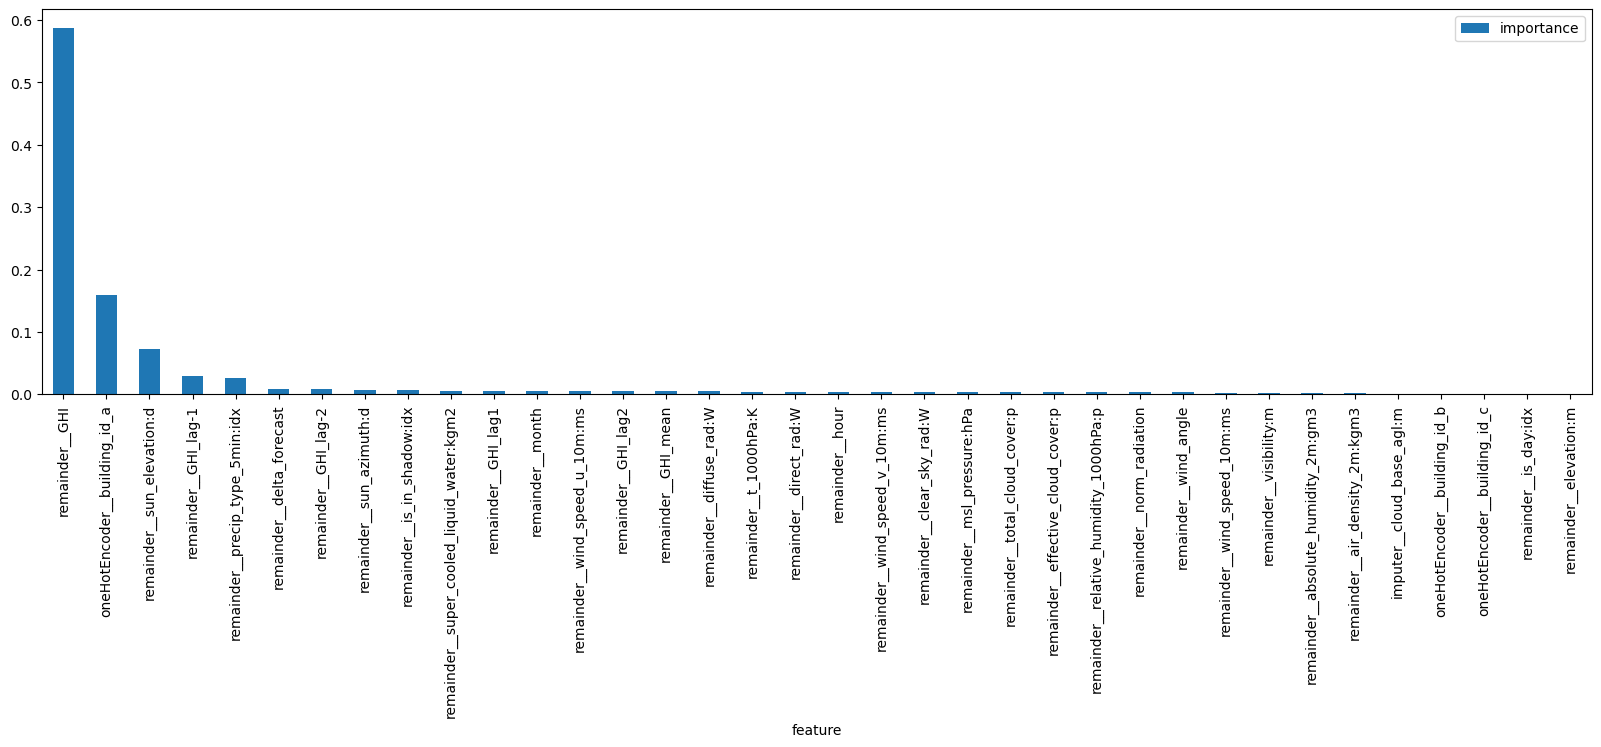

In [653]:
f_names = m1.steps[-3][1].get_feature_names_out()
f_importances = m1.steps[-1][1].feature_importances_

f_importances_df = pd.DataFrame({'feature': f_names, 'importance': f_importances})

f_importances_df = f_importances_df.sort_values(by='importance', ascending=False)

f_importances_df.plot.bar(x='feature', y='importance', figsize=(20, 5))


In [654]:
if type(m1_CV) == BayesSearchCV:
    _ = plot_objective(m1_CV.optimizer_results_[0])
    plt.show()

# Test model on estimated data
This is not perfect but should give an indication of how the model performs
The MAE is much lower than the MAE when uploading the predictions to the competition. The reason for this is, that the model has a higher MAE in the summer, where the test set is taken from.

In [655]:
# predict on estimated data
m1_pred = pd.Series(m1.predict(X_e))
#m1_pred = pd.Series(full_scaler.inverse_transform(m1_pred.values.reshape(-1, 1)).flatten())
#m1_pred = y_scaler.inverse_transform(m1_pred, X_e['building_id'])
Xy_e['m1_pred'] = m1_pred

# calculate abs diff
Xy_e['diff'] = np.abs(Xy_e['pv_measurement'] - Xy_e['m1_pred'])

# calculate mae
mae = Xy_e['diff'].mean()
print('MAE:', mae)


MAE: 380.0700041335164


<Axes: xlabel='time', ylabel='diff'>

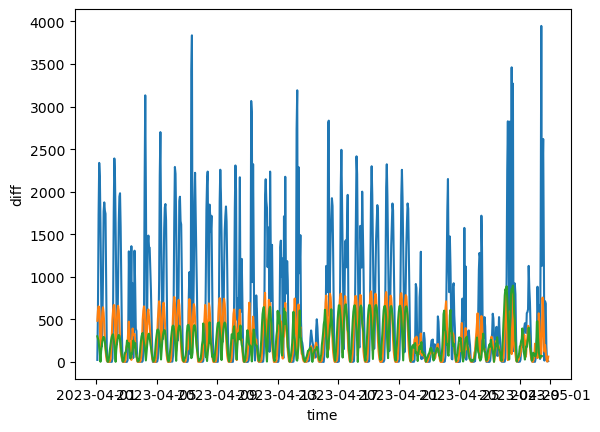

In [656]:
sns.lineplot(data=Xy_e, x='time', y='diff', hue='building_id', legend=False)

In [657]:
# Creating the submission file --> will later be done further below; just to test accuracy of own test method

m1.fit(X_, y_)

# prepare dataframes
y_test_pred = pd.Series(m1.predict(X_t))
# y_test_pred = pd.Series(full_scaler.inverse_transform(
#     y_test_pred.values.reshape(-1, 1)).flatten())
#y_test_pred = y_scaler.inverse_transform(y_test_pred, X_t['building_id']).copy()

# remove negative predictions
y_test_pred.iloc[y_test_pred < 0] = 0

# rename columns etc.
y_test_pred = y_test_pred.reset_index().rename(
    columns={'pv_measurement': 'prediction', 'index': 'id'})

# save submission file
y_test_pred.to_csv(
    'newTrainVal_bayesHyperparameters1000_SummerSplit_noScaling_feature_selection.csv', index=False, header=True)


#